With this notebook we want to test how many and which of the important features have been exploited by each isolation tree in a given isolation forest.

In [1]:
import os
import numpy as np
import pickle as pkl 
# import time
import matplotlib.pyplot as plt 
%matplotlib inline
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.utils import shuffle
# import shap
# import diffi.interpretability_module as interp
from diffi.utils import *

/Users/sebastianosanson/Documents/Master Thesis/Master-Thesis/mt_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [2]:
with open(os.path.join(os.getcwd(), 'dataset', 'syn_train.pkl'), 'rb') as f:
    data_tr = pkl.load(f)
with open(os.path.join(os.getcwd(), 'dataset', 'syn_test.pkl'), 'rb') as f:
    data_te = pkl.load(f)

X_tr = data_tr.iloc[:, :-1]
y_tr = data_tr.iloc[:, -1]

X_tr, y_tr = shuffle(X_tr, y_tr, random_state=0)

X_te = data_te.iloc[:, :-1]
y_te = data_te.iloc[:, -1]


In [3]:
print('Training set size: ', X_tr.shape)
print('Trainin label size: ', y_tr.shape)

print('Test set size: ', X_te.shape)
print('Test label size: ', y_te.shape)

Training set size:  (1000, 20)
Trainin label size:  (1000,)
Test set size:  (100, 20)
Test label size:  (100,)


## Train the Isolation Forest

In [ ]:
# iforest = IsolationForest(n_estimators=100, max_samples=256, contamination=0.1, random_state=0, bootstrap=False)
# iforest.fit(X_tr)
# y_tr_pred = np.array(iforest.decision_function(X_tr) < 0).astype(int)    # > 0 -> True -> 1; < 0 -> False -> 0
# f1 = f1_score(y_tr, y_tr_pred)
# print('F1 score on training data: {:.4f}'.format(f1))

F1 score on training data: 0.4300


In [ ]:
# y_te_pred = np.array(iforest.decision_function(X_te) < 0).astype(int)    
# print('Detected anomalies: {} out of {}'.format(int(sum(y_te_pred)), len(y_te)))

Detected anomalies: 50 out of 100


Printing the features rank computed by global DIFFI.

In [49]:
sorted_idx, avg_f1, fi_means, fi_std, features_per_forest = diffi_ranks(X=X_tr.to_numpy(), y=y_tr.to_numpy(), n_trees=100, 
                                                                        max_samples=256, n_iter=2, contamination=0.1)
print('Average F1 score: {:.4f}'.format(avg_f1))
# print('Ranked features: ', sorted_idx)
# print('Feature importance means: ', fi_means)
# print('Feature importance std: ', fi_std)

Average F1 score: 0.4000


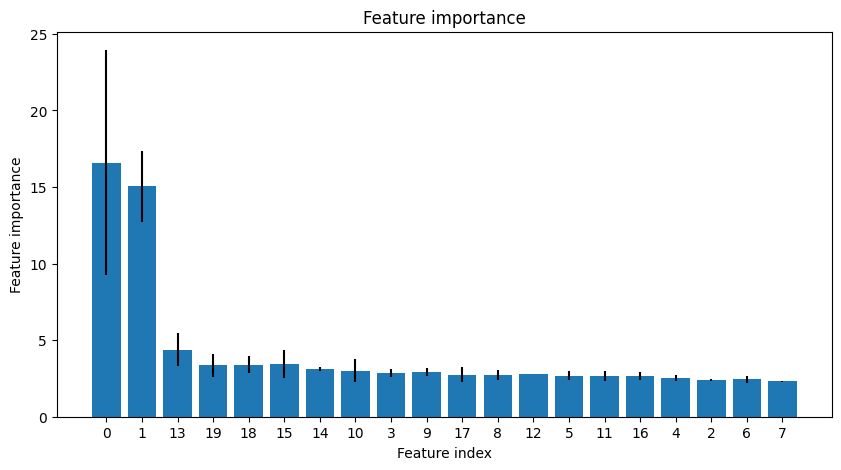

In [50]:
# plot the features importance
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_idx)), fi_means[sorted_idx], yerr=fi_std[sorted_idx])
plt.xticks(range(len(sorted_idx)), sorted_idx)
plt.xlabel('Feature index')
plt.ylabel('Feature importance')
plt.title('Feature importance')
plt.show()

Notice that the two most important features are the meaningful ones, while the other are the noise ones (in according to synthetic dataset).

In [51]:
two_most_important_features = sorted_idx[:2]
print('Two most important features:', two_most_important_features)

Two most important features: [0 1]


In [52]:
features_per_forest = np.array(features_per_forest, dtype=object)
# print(features_per_forest.shape)  
print('Number of forest/s: ', len(features_per_forest))
print('Number of tree/s: ', [len(features_per_forest[i]) for i in range(len(features_per_forest))])

# for i, forest in enumerate(features_per_forest):
#     print('Forest {}:'.format(i))
#     for j, tree in enumerate(forest):
#         print('Number of features in tree {}: {}'.format(j, len(tree)))
#         print('Features in tree {} in forest {}: {}'.format(j, i, tree))

Number of forest/s:  2
Number of tree/s:  [100, 100]


In [26]:
# for i, tree in enumerate(iforest.estimators_):
    # print(f"Tree {i}:")
    # print(f"  Depth: {tree.tree_.max_depth}")
    # print(f"  Number of nodes: {tree.tree_.node_count}")

    # features_per_tree.append(tree.tree_.feature)
    # print(f"  Features used: {tree.tree_.feature}")    

# extracted features from one isolation forest 
# features_per_tree = [tree.tree_.feature for _, tree in enumerate(iforest.estimators_)]
# print('Features per tree:', features_per_tree)

In [9]:
# num_features_per_tree = [len(tree_features) for tree_features in features_per_tree]
# print('Number of features used by each tree:', num_features_per_tree)

**TO-DO**:
- capire che statistiche tirare fuori da `features_per_tree`:
    * percentuale d'uso delle features nell'isolation forest -> osservarne il trend riguardante l'uso delle `k` feature più importanti rispetto alle altre (queste feature sono le stesse che serviranno per effettuare gli *isolation split*)
    * quante volte sono state utilizzate le `two_most_important_features` in ciascun isolation tree (percentuale di utilizzo)
        * calcolare la media della percentuale di utilizzo delle `two_most_important_features`
            * contare gli isolation tree con percentuale di utilizzo delle `two_most_important_features` > della media
    * altro?
- ha senso quando si vanno ad instaziare più foreste tracciare l'uso globale delle feature per ciascuna foresta?
- altro?


## Global features usage in Isolation Forest

We compute the usage of each feature over the Isolation Forest

In [53]:
usage_per_forest = np.zeros((len(features_per_forest), X_tr.shape[1]), 
                            dtype=object)    # shape: (number of forests, number of features)
usage_per_tree = np.zeros((len(features_per_forest), len(features_per_forest[0]), X_tr.shape[1]), 
                          dtype=object)  # shape: (number of forests, number of trees, number of features)


for i in range(X_tr.shape[1]):                                                      # for each feature                                     
    for j, forest in enumerate(features_per_forest):                                # for each forest
        for k, tree in enumerate(forest):                                           # for each tree
            # count the number of times feature i is used in tree k in forest j
            usage_per_tree[j, k, i] = np.sum([1 for feature in tree if feature == i])   
        # count the number of times feature i is used in forest j
        usage_per_forest[j, i] = np.sum(usage_per_tree[j, :, i])                          

print(np.array(usage_per_tree, dtype=object).shape)
print(np.array(usage_per_forest, dtype=object).shape)

(2, 100, 20)
(2, 20)


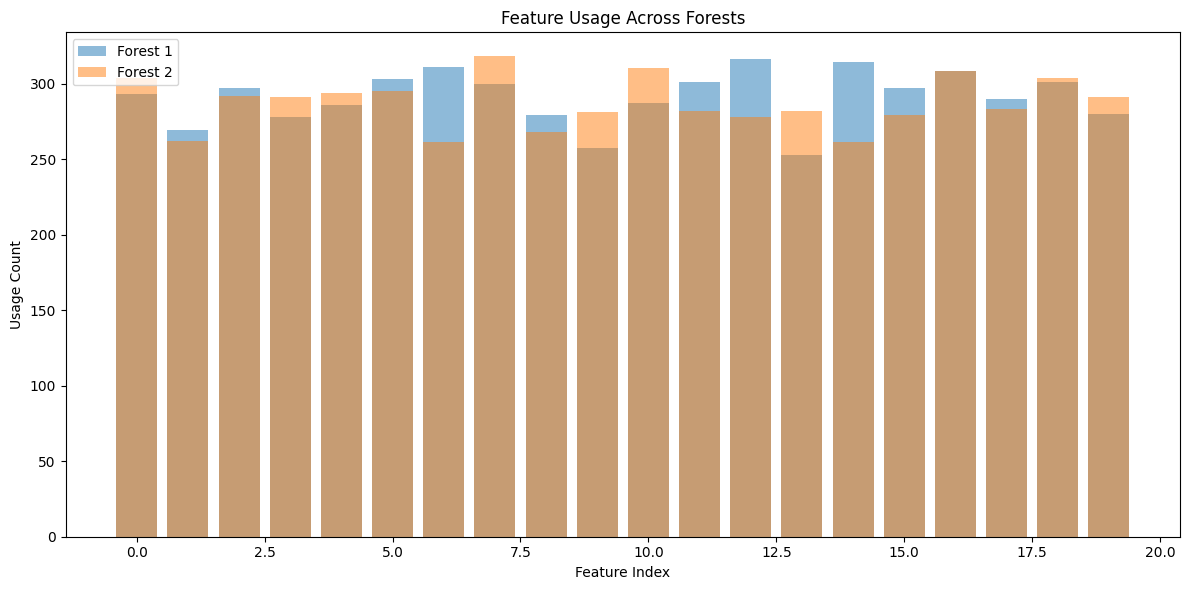

In [54]:
plt.figure(figsize=(12, 6))
for i in range(usage_per_forest.shape[0]):
    plt.bar(range(usage_per_forest.shape[1]), usage_per_forest[i], alpha=0.5, label=f'Forest {i+1}')
plt.xlabel('Feature Index')
plt.ylabel('Usage Count')
plt.title('Feature Usage Across Forests')
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
num_forests = usage_per_tree.shape[0]
num_trees = usage_per_tree.shape[1]
num_features = usage_per_tree.shape[2]

## `two_most_important_features` usage 

Counting how many times the `two_most_important_features`are used in each Isolation Tree

In [ ]:
num_forests = len(features_per_forest)
num_trees = len(features_per_forest[0])

two_most_important_features_usage = np.zeros((len(two_most_important_features), num_trees))
# print(two_most_important_features_usage.shape)

for i in range(len(two_most_important_features)):
    for j, forest in enumerate(features_per_forest):
        for k, tree in enumerate(forest):
            two_most_important_features_usage[i, k] = usage_per_tree[j, k, i] / len(tree)  

print('Two most important features usage:', two_most_important_features_usage)

# TODO: add forest dimension into the `two_most_important_features_usage` array

Two most important features usage: [[0.0212766  0.04       0.01694915 0.00787402 0.01324503 0.00763359
  0.01941748 0.04575163 0.03478261 0.03960396 0.00621118 0.03361345
  0.02857143 0.03738318 0.03100775 0.06976744 0.02409639 0.01574803
  0.03314917 0.00990099 0.01449275 0.01574803 0.01342282 0.03225806
  0.03773585 0.02366864 0.00840336 0.00621118 0.00787402 0.03816794
  0.         0.01960784 0.0212766  0.02758621 0.00775194 0.02290076
  0.02105263 0.02673797 0.00552486 0.02453988 0.         0.02608696
  0.02721088 0.00869565 0.01481481 0.01075269 0.01754386 0.04210526
  0.02061856 0.04       0.04950495 0.01626016 0.04580153 0.06493506
  0.03816794 0.02912621 0.0137931  0.04137931 0.02702703 0.00900901
  0.05479452 0.02797203 0.03797468 0.02222222 0.01941748 0.03157895
  0.         0.01714286 0.02247191 0.02617801 0.04210526 0.00787402
  0.02654867 0.02040816 0.03067485 0.03305785 0.03225806 0.02290076
  0.03157895 0.07079646 0.04597701 0.02325581 0.03157895 0.02531646
  0.02614379 

Now we are going to normalize the results to the range [0, 1]

In [44]:
two_most_important_features_usage_probabilities = two_most_important_features_usage / np.max(two_most_important_features_usage, axis=1, keepdims=True)

# print('Two most important features usage probabilities:', two_most_important_features_usage_probabilities)

Plotting the usage probabilities of `two_most_important_features` across isolation trees

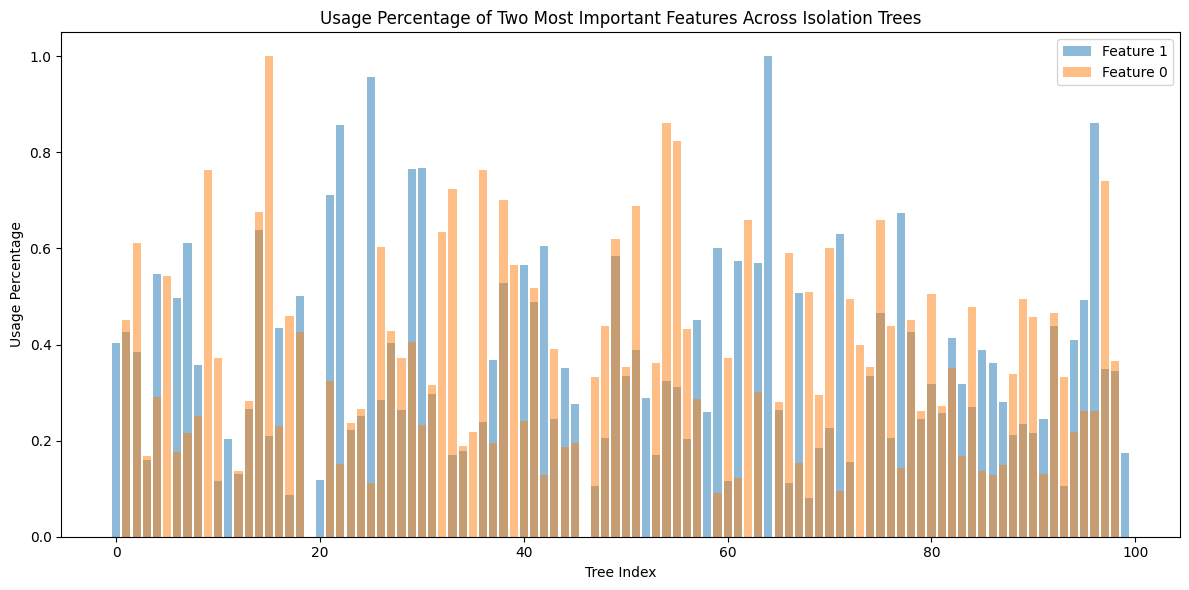

In [45]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(two_most_important_features):
    plt.bar(range(len(two_most_important_features_usage_probabilities[i])), 
            two_most_important_features_usage_probabilities[i], 
            alpha=0.5, label=f'Feature {feature}')
plt.xlabel('Tree Index')
plt.ylabel('Usage Percentage')
plt.title('Usage Percentage of Two Most Important Features Across Isolation Trees')
plt.legend()
plt.tight_layout()
plt.show()

## Average usage

Calculating the average of the `two_most_important_features_usage_probabilities` for each `two_most_important_features`

In [46]:
average_usage_probabilities = np.mean(two_most_important_features_usage_probabilities, axis=1)
for i, feature in enumerate(two_most_important_features):
    print(f"Average usage probability for Feature {feature}: {average_usage_probabilities[i]:.4f}")

Average usage probability for Feature 1: 0.3358
Average usage probability for Feature 0: 0.3488


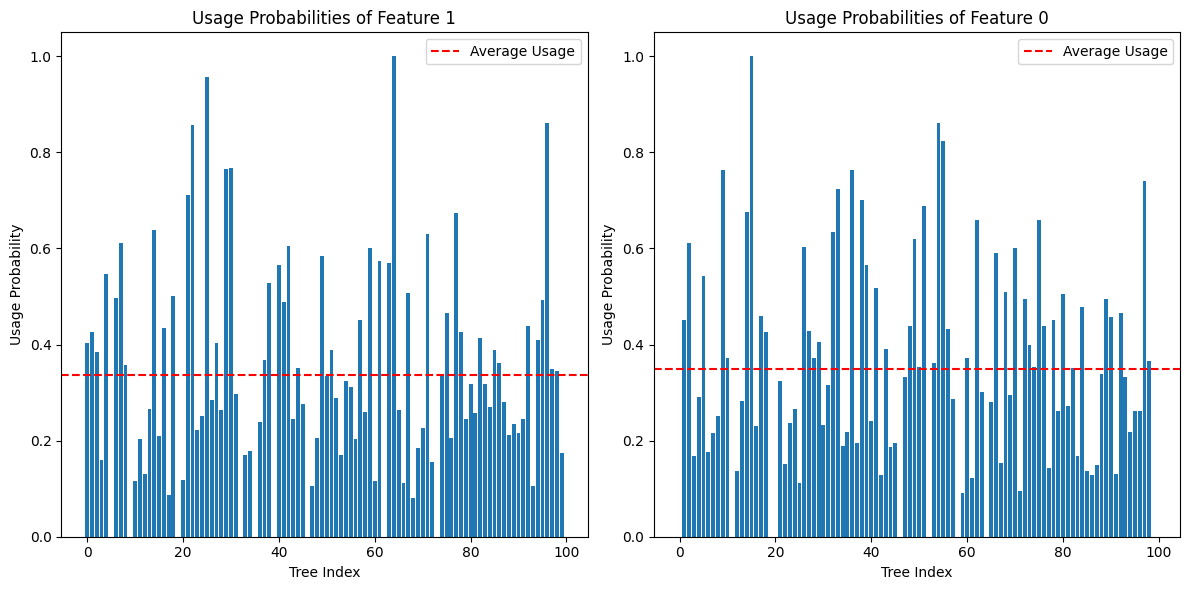

In [47]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(two_most_important_features):
    plt.subplot(1, 2, i+1)
    plt.bar(range(len(two_most_important_features_usage_probabilities[i])), two_most_important_features_usage_probabilities[i])
    plt.axhline(y=average_usage_probabilities[i], color='r', linestyle='--', label='Average Usage')
    plt.xlabel('Tree Index')
    plt.ylabel('Usage Probability')
    plt.title('Usage Probabilities of Feature {}'.format(feature))
    plt.legend()
plt.tight_layout()
plt.show()

In [48]:
trees_above_average = np.sum(two_most_important_features_usage_probabilities > average_usage_probabilities[:, np.newaxis], axis=1)

for i, feature in enumerate(two_most_important_features):
    print(f"Number of trees where Feature {feature} usage > average: {trees_above_average[i]} out of {len(features_per_tree)}")

Number of trees where Feature 1 usage > average: 43 out of 100
Number of trees where Feature 0 usage > average: 47 out of 100
